# Time series compression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# sns.set_theme()

In [15]:
time = np.linspace(0, 100, 1000)                    # Время: от 0 до 100, 1000 точек
amplitude = np.sin(2 * np.pi * 0.1 * time)          # Основная синусоида
noise = np.random.normal(0, 0.3, size=len(time))    # Добавление шума
signal = amplitude + noise                          # Итоговый временной ряд
amplitude2 = np.sin(2 * np.pi * 0.3 * time)             
amplitude3 = np.cos(2 * np.pi * 0.3 * time)
signal = amplitude + noise  + amplitude2  + amplitude3    # Итоговый временной ряд

signal = signal.astype('float32')

In [ ]:
# signal.shape

(1000,)

In [41]:
signal = pd.read_csv('../data/small_data.csv', usecols=['temp_ice']).values[:30000].reshape(-1)

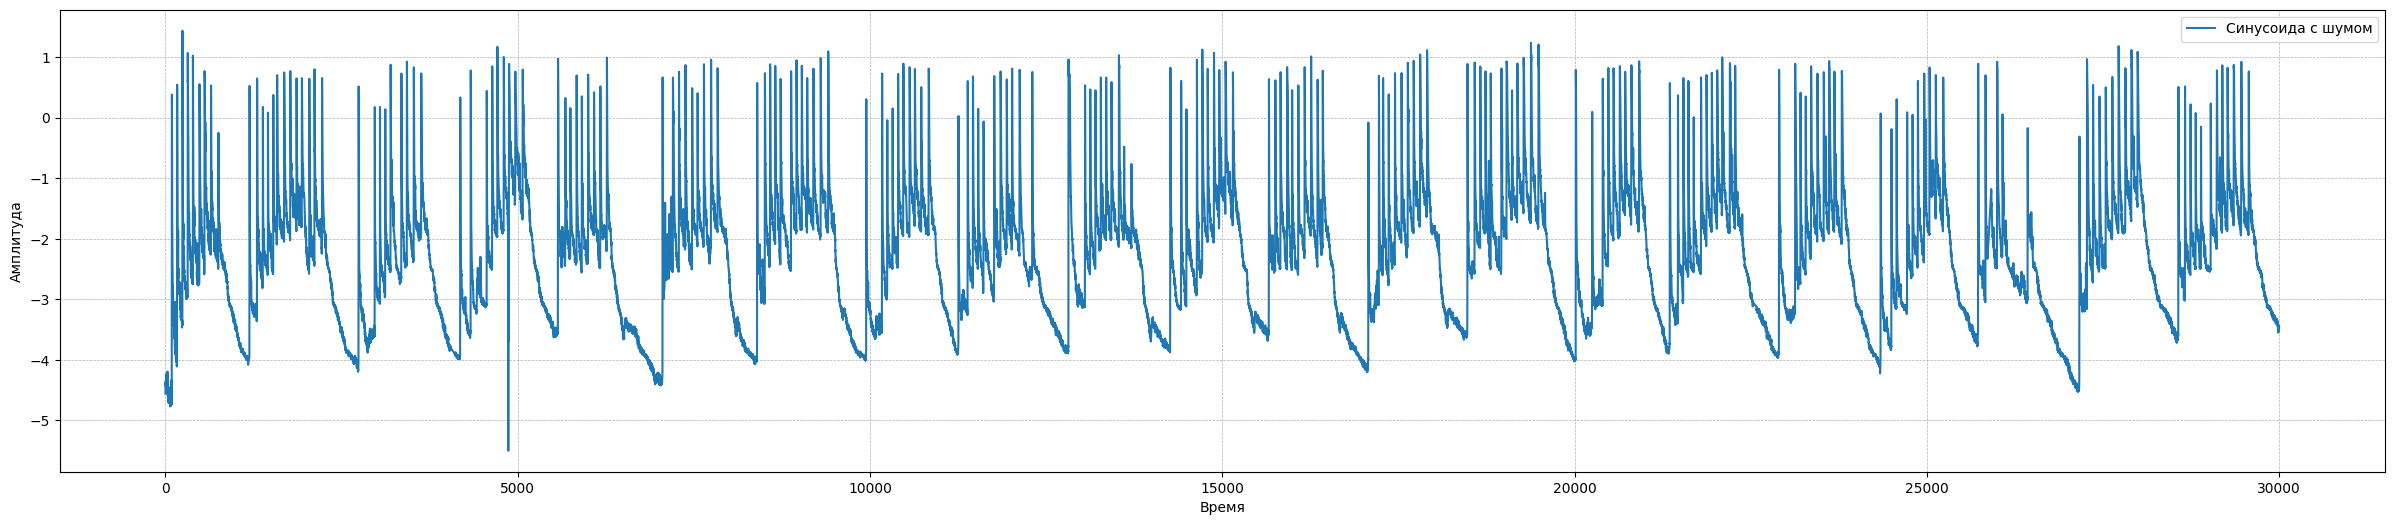

In [42]:
plt.figure(figsize=(30, 6))
# plt.plot(time, signal, label="Синусоида с шумом")
plt.plot(signal, label="Синусоида с шумом")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()                      

## Preprocessing

In [43]:
window_size = 60
step = 30

X = []
y = []
for i in range(0, len(signal) - window_size - step):
    X.append(signal[i:i + window_size])
    y.append(signal[i + window_size + step])

X = np.array(X)
y = np.array(y)

In [44]:
X.shape, y.shape

((29910, 60), (29910,))

## Compression methods

In [45]:
def plot_reconstructed_data(X_reconstructed, length=400):
    plt.figure(figsize=(30, 7))
    plt.plot(X[:, 0][:length], label="Оригинальное окно")
    plt.plot(X_reconstructed[:, 0][:length], label="Восстановленное окно", linestyle="--")
    plt.title("Сравнение оригинальных и восстановленных данных")
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    plt.show()

In [61]:
N_COMPRESSED_FEATURES = 5

### Linear methods

#### Principal component analysis

In [62]:
from sklearn.decomposition import PCA

In [63]:
n_components = N_COMPRESSED_FEATURES
pca = PCA(n_components=n_components)

X_pca_compressed = pca.fit_transform(X)
X_pca_reconstructed = pca.inverse_transform(X_pca_compressed)

In [64]:
X.shape, X_pca_compressed.shape, X_pca_reconstructed.shape 

((29910, 60), (29910, 5), (29910, 60))

In [65]:
pca_explained_variance = pca.explained_variance_ratio_
print(f"Доля объяснённой дисперсии каждой компонентой: {pca_explained_variance}")
print(f"Суммарная доля объяснённой дисперсии: {np.sum(pca_explained_variance)}")

Доля объяснённой дисперсии каждой компонентой: [0.74153348 0.07840024 0.04628467 0.02760555 0.02033111]
Суммарная доля объяснённой дисперсии: 0.9141550469355202


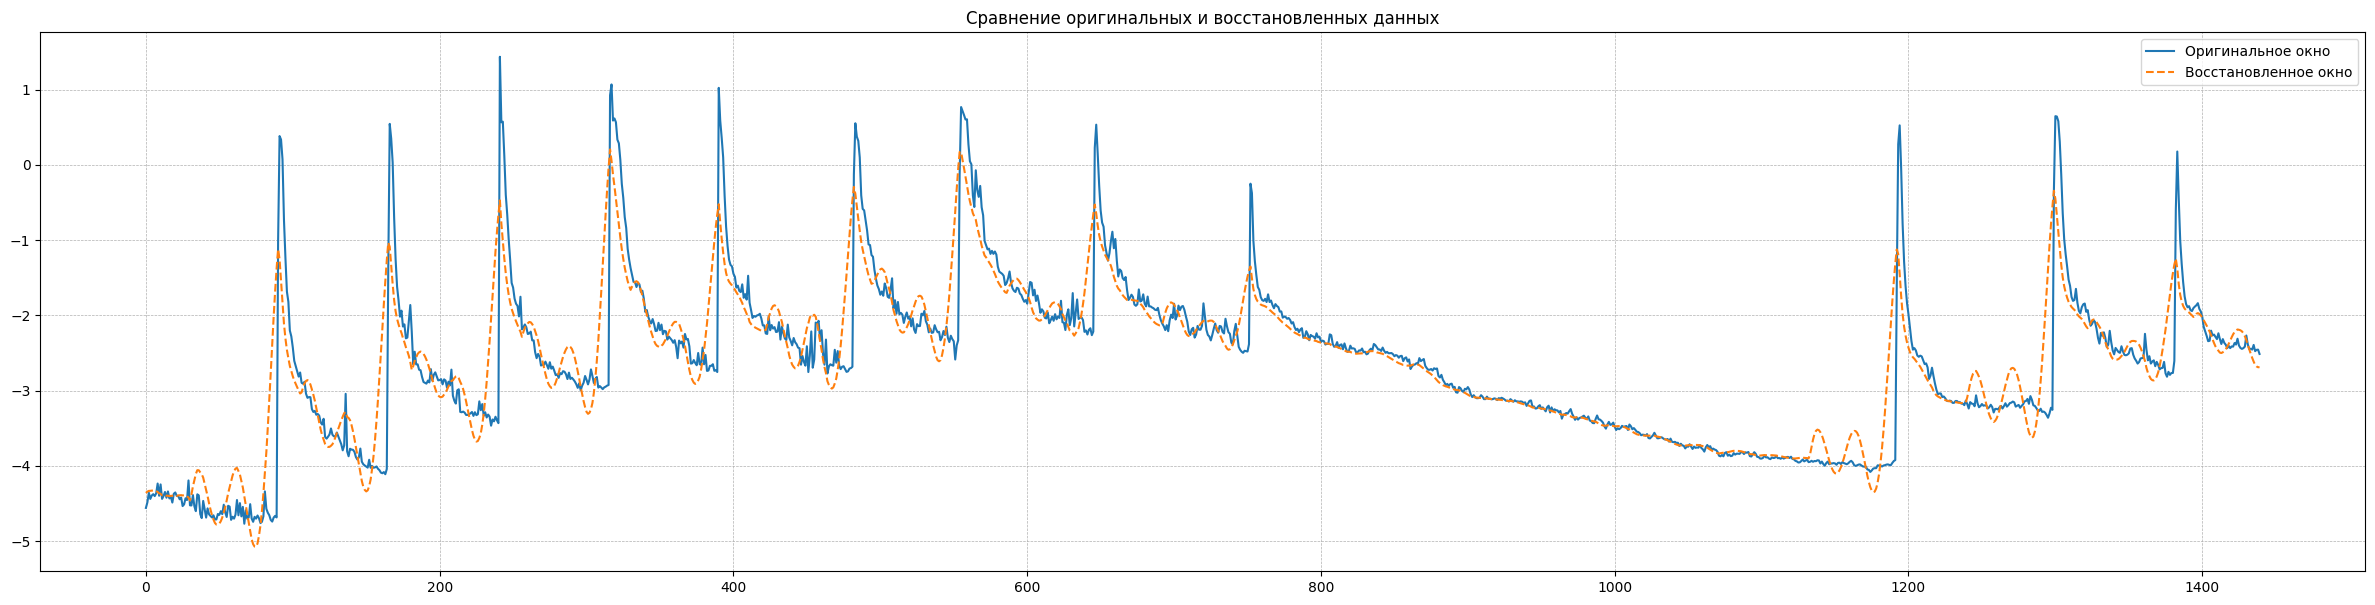

In [68]:
plot_reconstructed_data(X_pca_reconstructed, 1440)

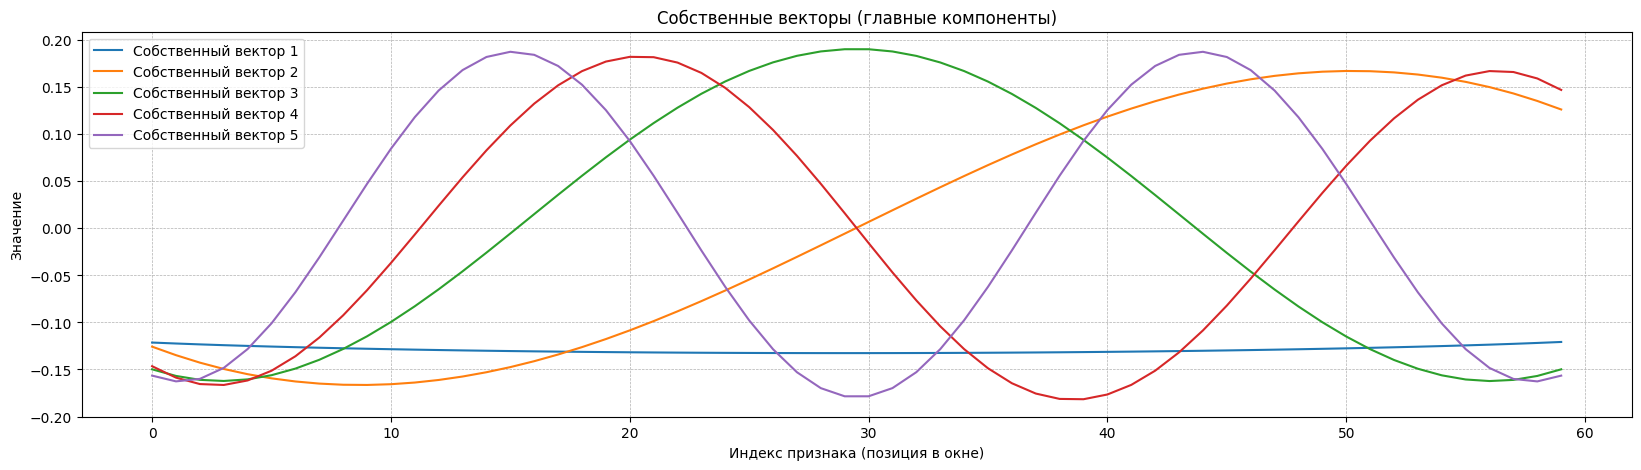

In [69]:
# Данные собственных векторов
eigenvectors = pca.components_  # Размер: (n_components, window_size)

# Визуализация
plt.figure(figsize=(20, 5))
for i, eigenvector in enumerate(eigenvectors):
    plt.plot(eigenvector, label=f'Собственный вектор {i + 1}')
plt.title('Собственные векторы (главные компоненты)')
plt.xlabel('Индекс признака (позиция в окне)')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

#### Singular value decomposition

In [70]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)

In [71]:
U.shape, S.shape, Vt.shape

((29910, 60), (60,), (60, 60))

In [72]:
k = N_COMPRESSED_FEATURES 
X_svd_compressed = U[:, :k] * S[:k]
X_svd_reconstructed = np.dot(U[:, :2], np.dot(np.diag(S[:2]), Vt[:2, :]))

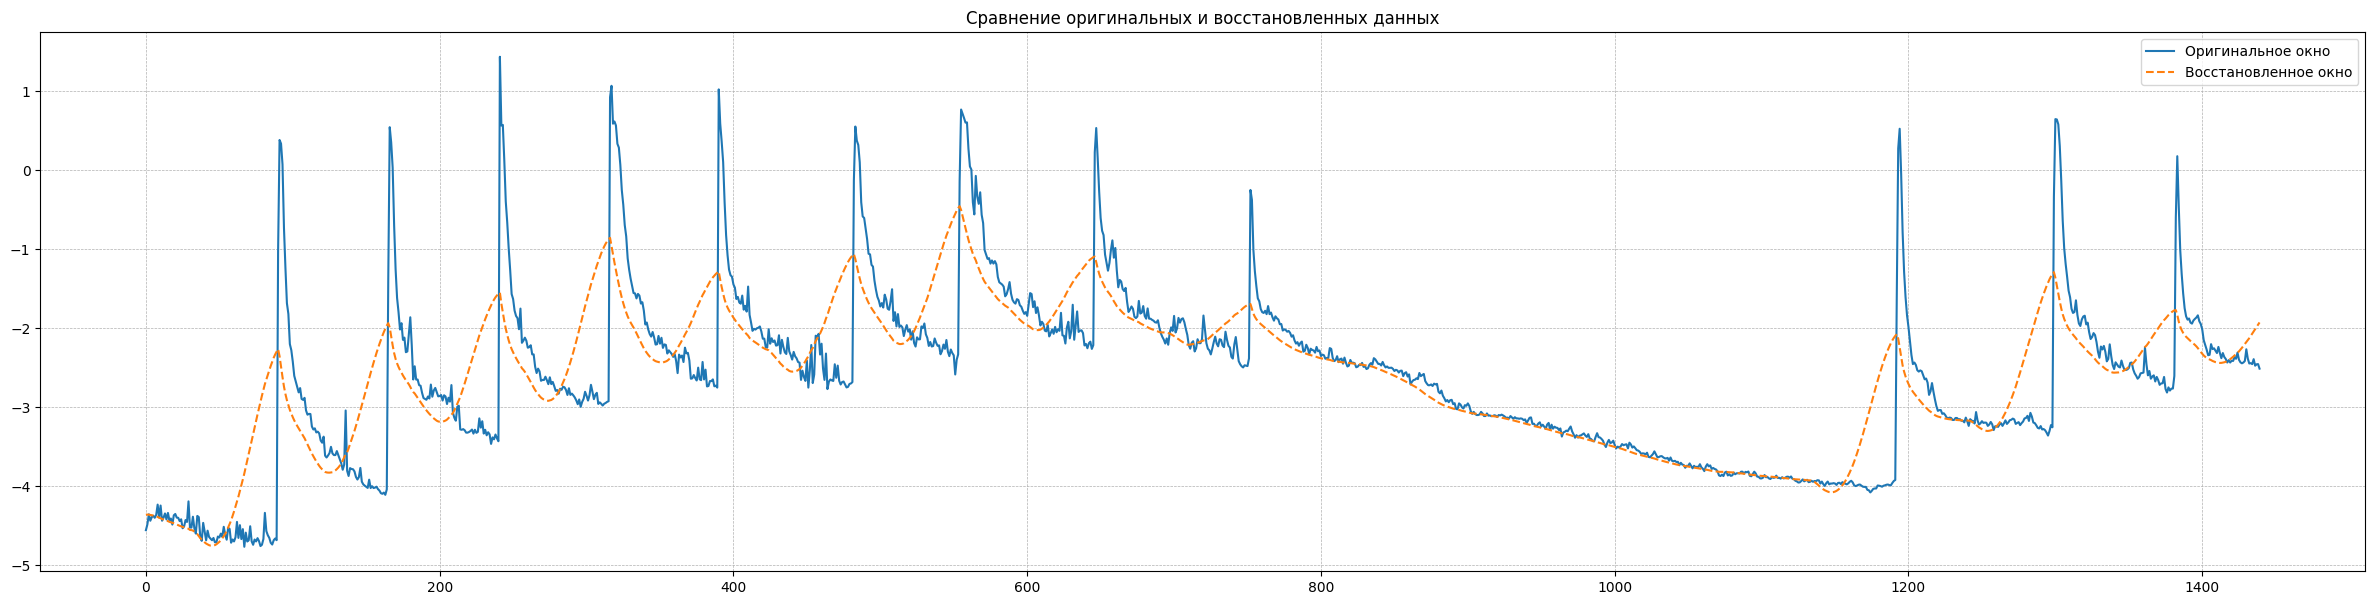

In [73]:
plot_reconstructed_data(X_svd_reconstructed, 1440)

In [74]:
explained_variance = (S ** 2) / np.sum(S ** 2)
print("Доля объяснённой дисперсии каждой компонентой:", explained_variance[:2])
print("Суммарная доля объяснённой дисперсии:", np.sum(explained_variance[:2]))

Доля объяснённой дисперсии каждой компонентой: [0.95510946 0.01359432]
Суммарная доля объяснённой дисперсии: 0.9687037830920705


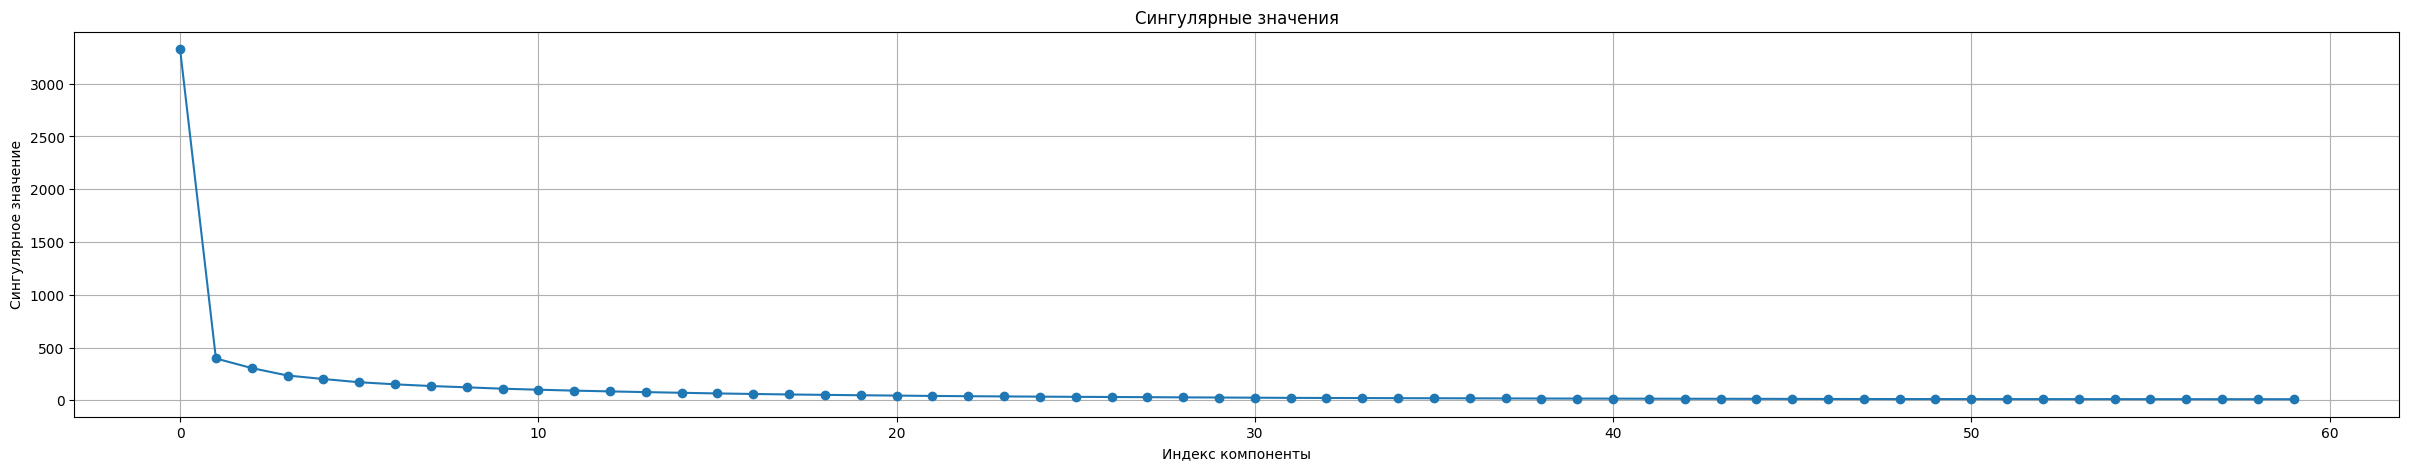

In [75]:
plt.figure(figsize=(30, 5))
plt.plot(S, marker="o")
plt.title("Сингулярные значения")
plt.xlabel("Индекс компоненты")
plt.ylabel("Сингулярное значение")
plt.grid(True)
plt.show()

### Nonlinear methods (Autoencoders, t-SNE, UMAP)

#### UMAP

In [76]:
import umap
from sklearn.manifold import trustworthiness

In [77]:
n_components = N_COMPRESSED_FEATURES
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=n_components)
X_umap_compressed = reducer.fit_transform(X)
X_umap_reconstructed = reducer.inverse_transform(X_umap_compressed)

KeyboardInterrupt: 

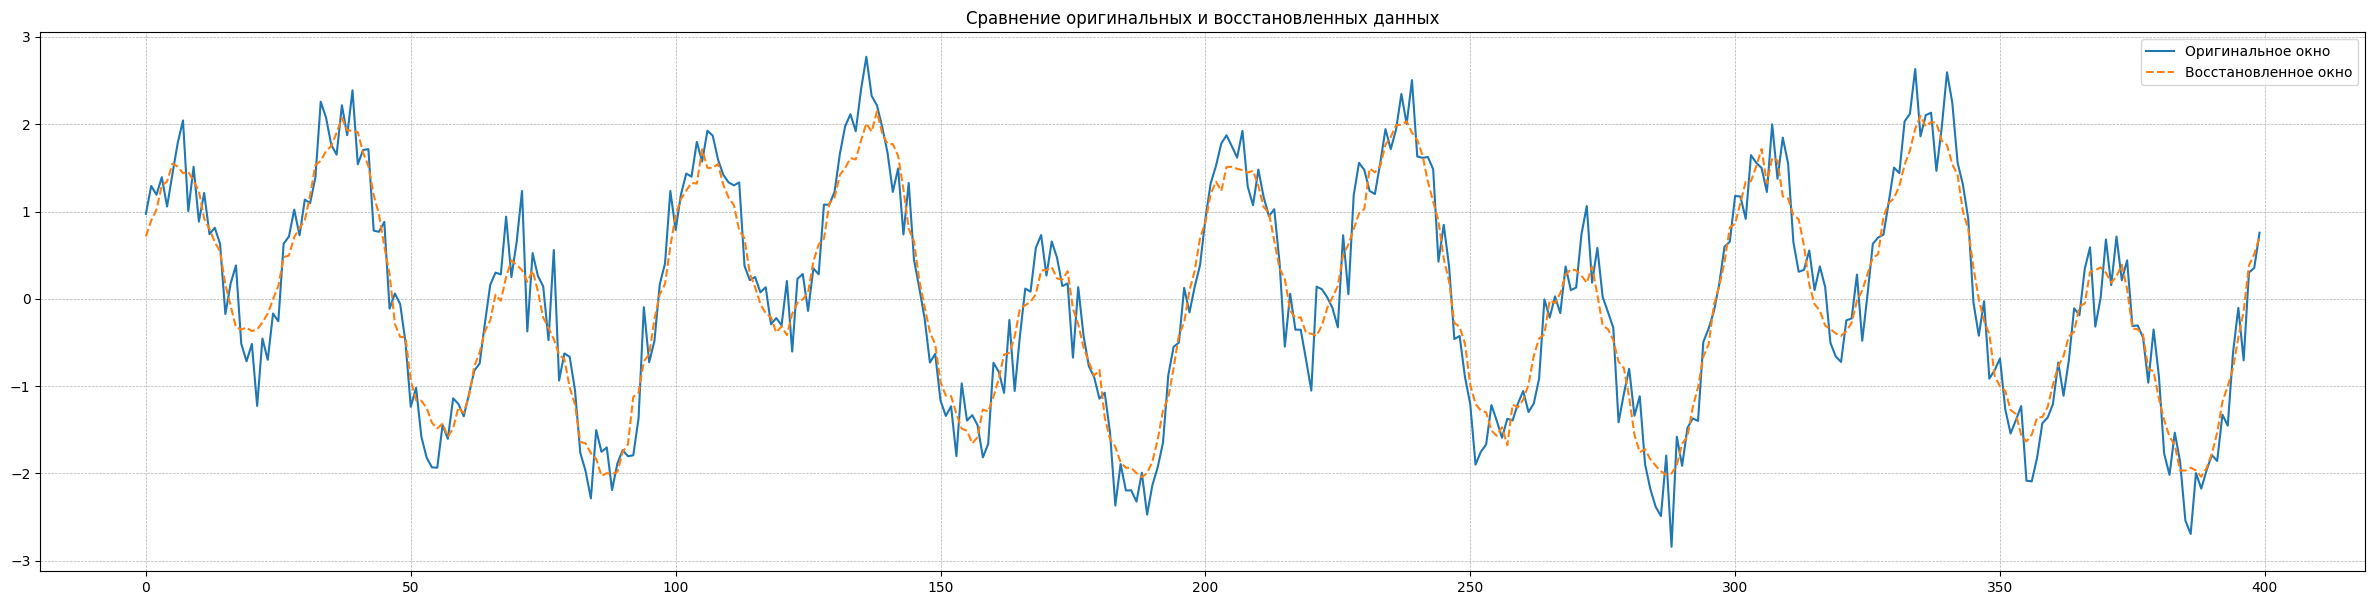

In [ ]:
plot_reconstructed_data(X_umap_reconstructed, 1440)

In [ ]:
# Оценка Trustworthiness
trust = trustworthiness(X, X_umap_compressed)
print(f"Trustworthiness: {trust:.3f}")

Trustworthiness: 0.996


#### t-SNE (t-Distributed Stohastic Neighbor Embedding)

In [ ]:
from sklearn.manifold import TSNE

In [384]:
n_components = 3

tsne = TSNE(n_components=n_components, perplexity=30, random_state=42, n_iter=1000)
X_tsne_compressed = tsne.fit_transform(X)
# Обратного преобразования у tsne не существует
X_tsne_reconstructed = None

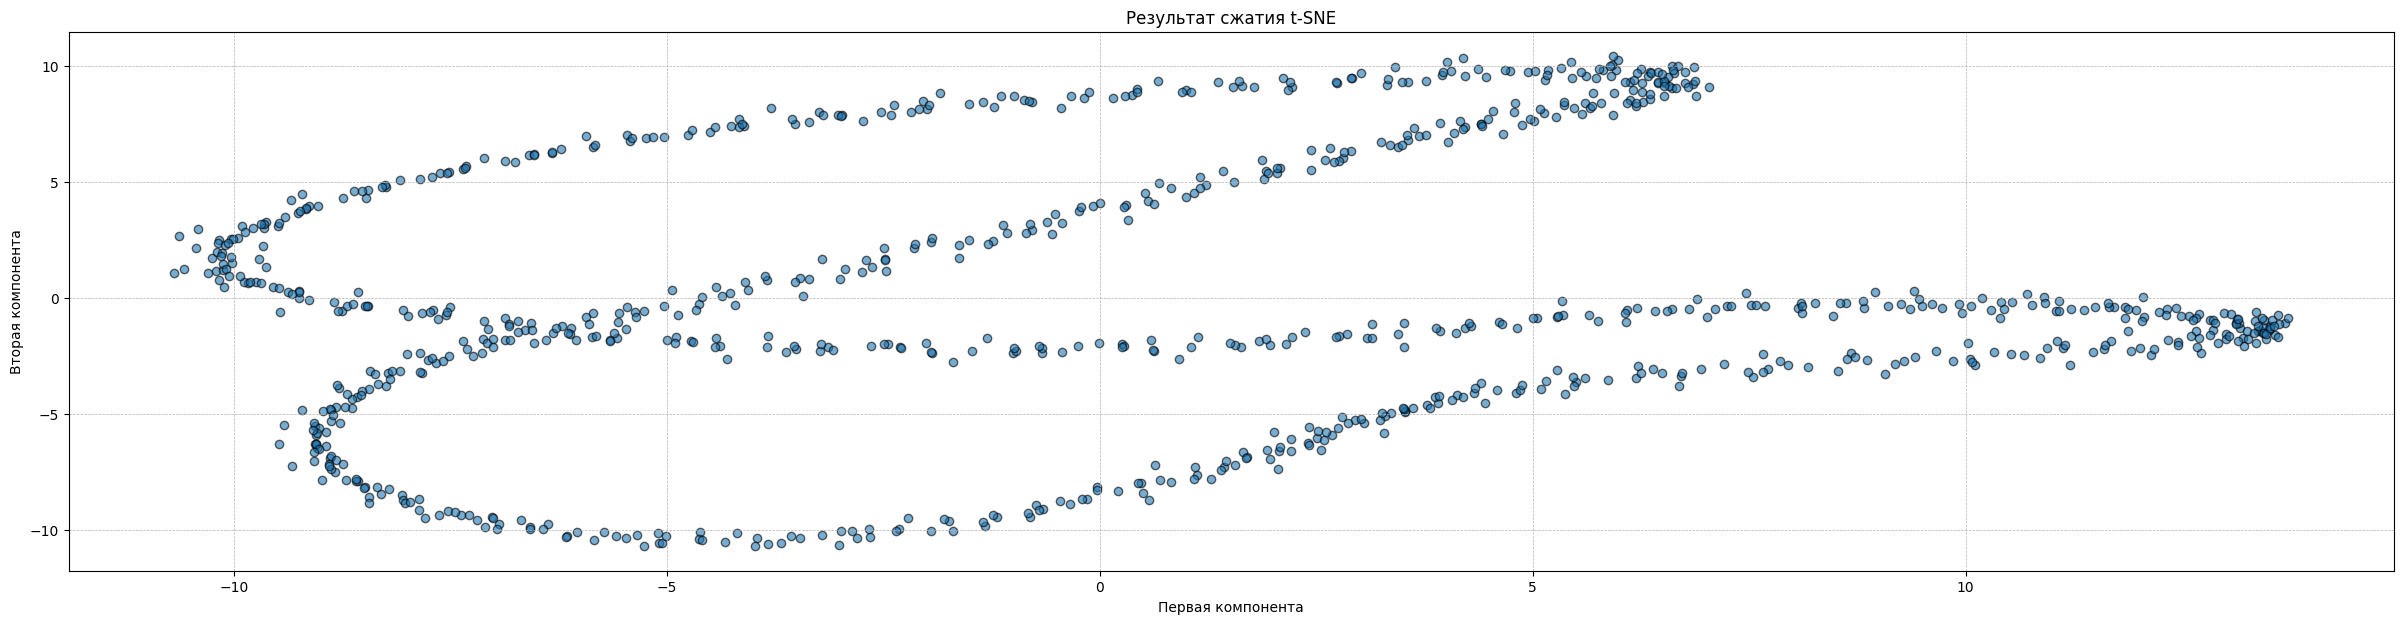

In [385]:
# Визуализация
plt.figure(figsize=(30, 7))
plt.scatter(X_tsne_compressed[:, 0], X_tsne_compressed[:, 1], alpha=0.6, edgecolor='k')
plt.title("Результат сжатия t-SNE")
plt.xlabel("Первая компонента")
plt.ylabel("Вторая компонента")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Глобальная структура:**
- Данные организованы в виде замкнутой эллиптической структуры. Это указывает на то, что исходные данные имеют периодическую природу, например, синусоиды.
- Закрытая форма говорит о повторяемости шаблонов в данных, что логично для периодических временных рядов.

**Локальная структура:**
- Каждая точка в сжатом пространстве соответствует одному окну временного ряда.
- Близость точек указывает на схожесть временных окон (например, их форма или значения близки друг к другу).

#### Autoencoder

In [78]:
import torch
import torch.nn as nn

In [89]:
# Параметры
input_dim = 60                      # Длина окна
latent_dim = N_COMPRESSED_FEATURES  # Латентное пространство
batch_size = 32
epochs = 50
learning_rate = 0.001


class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)

        return latent, reconstructed


model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
# Функция потерь и оптимизатор
criterion = nn.MSELoss()  # MSE для несжатыx данных
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [90]:
# Обучение
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for i in range(0, len(X[1440:]), batch_size):
        # Формируем батчи
        batch = torch.tensor(X[i:i+batch_size], dtype=torch.float32)

        # Прямой проход
        _, reconstructed = model(batch)

        # Вычисление потерь
        loss = criterion(reconstructed, batch)

        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Суммируем потери для текущей эпохи
        epoch_loss += loss.item()

    print(f"Эпоха {epoch + 1}/{epochs}, Потери: {epoch_loss:.4f}")

# Получение сжатых данных
with torch.no_grad():
    X_ae_compressed, X_ae_reconstructed = model(torch.tensor(X, dtype=torch.float32))

Эпоха 1/50, Потери: 398.6661
Эпоха 2/50, Потери: 114.5233
Эпоха 3/50, Потери: 84.6005
Эпоха 4/50, Потери: 68.5506
Эпоха 5/50, Потери: 57.3250
Эпоха 6/50, Потери: 51.6321
Эпоха 7/50, Потери: 48.0545
Эпоха 8/50, Потери: 46.2226
Эпоха 9/50, Потери: 44.0133
Эпоха 10/50, Потери: 41.2957
Эпоха 11/50, Потери: 38.7903
Эпоха 12/50, Потери: 36.8232
Эпоха 13/50, Потери: 35.3331
Эпоха 14/50, Потери: 34.2422
Эпоха 15/50, Потери: 33.3021
Эпоха 16/50, Потери: 32.4317
Эпоха 17/50, Потери: 31.5876
Эпоха 18/50, Потери: 31.0032
Эпоха 19/50, Потери: 30.5019
Эпоха 20/50, Потери: 30.1238
Эпоха 21/50, Потери: 29.9801
Эпоха 22/50, Потери: 29.7999
Эпоха 23/50, Потери: 29.5453
Эпоха 24/50, Потери: 29.0100
Эпоха 25/50, Потери: 28.5296
Эпоха 26/50, Потери: 28.1699
Эпоха 27/50, Потери: 27.8661
Эпоха 28/50, Потери: 27.7214
Эпоха 29/50, Потери: 27.5400
Эпоха 30/50, Потери: 27.4869
Эпоха 31/50, Потери: 27.1011
Эпоха 32/50, Потери: 26.7849
Эпоха 33/50, Потери: 26.6102
Эпоха 34/50, Потери: 26.3619
Эпоха 35/50, Потери: 

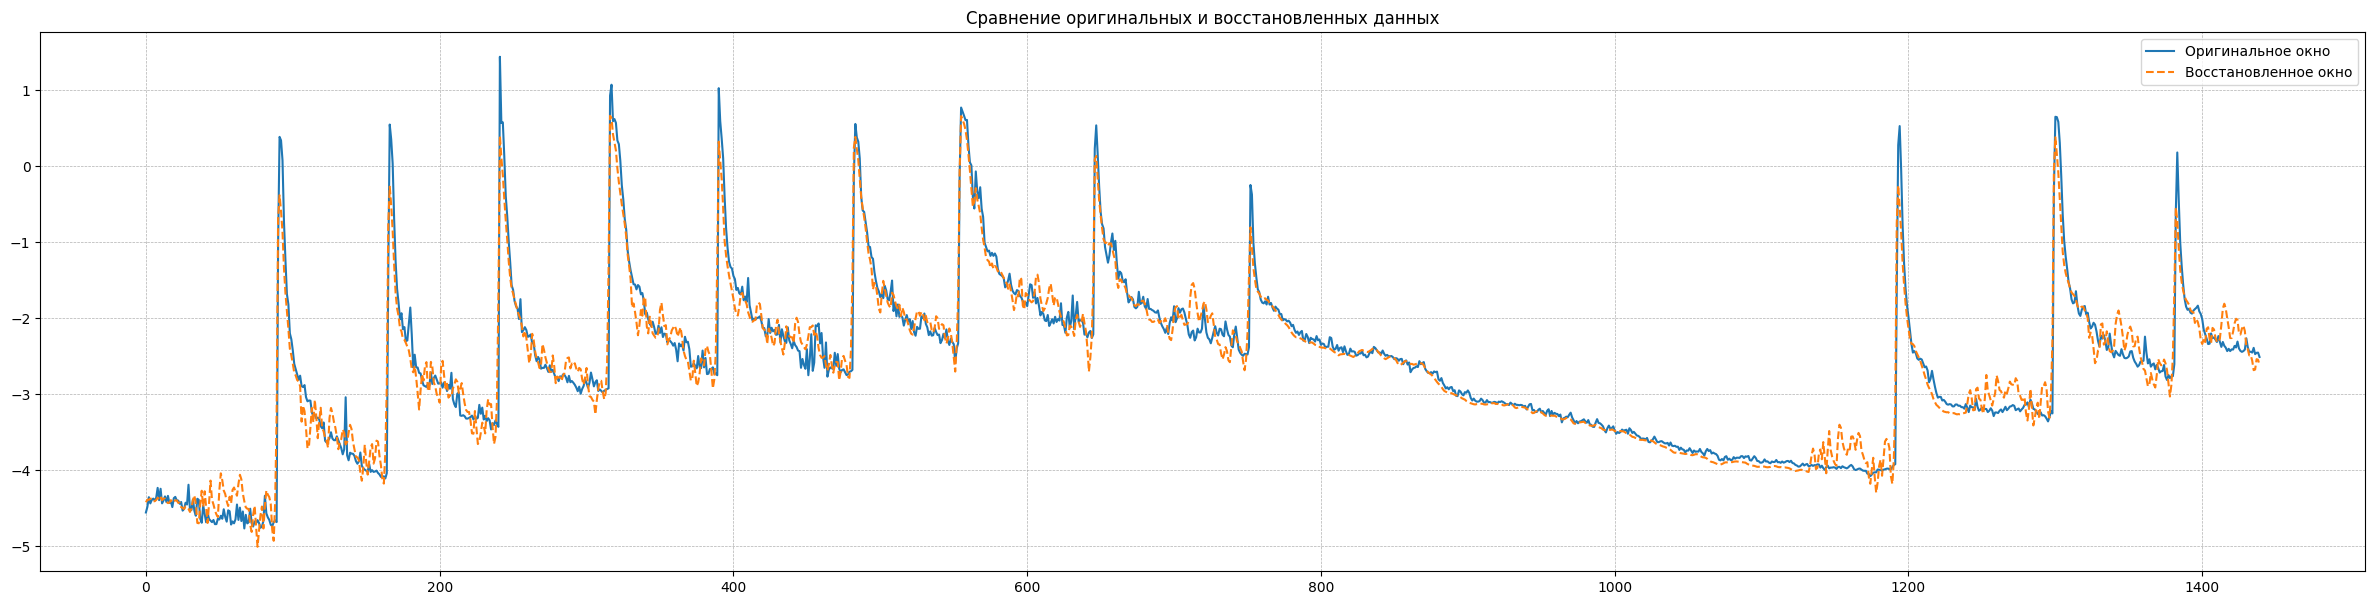

In [87]:
plot_reconstructed_data(X_ae_reconstructed, 1440)

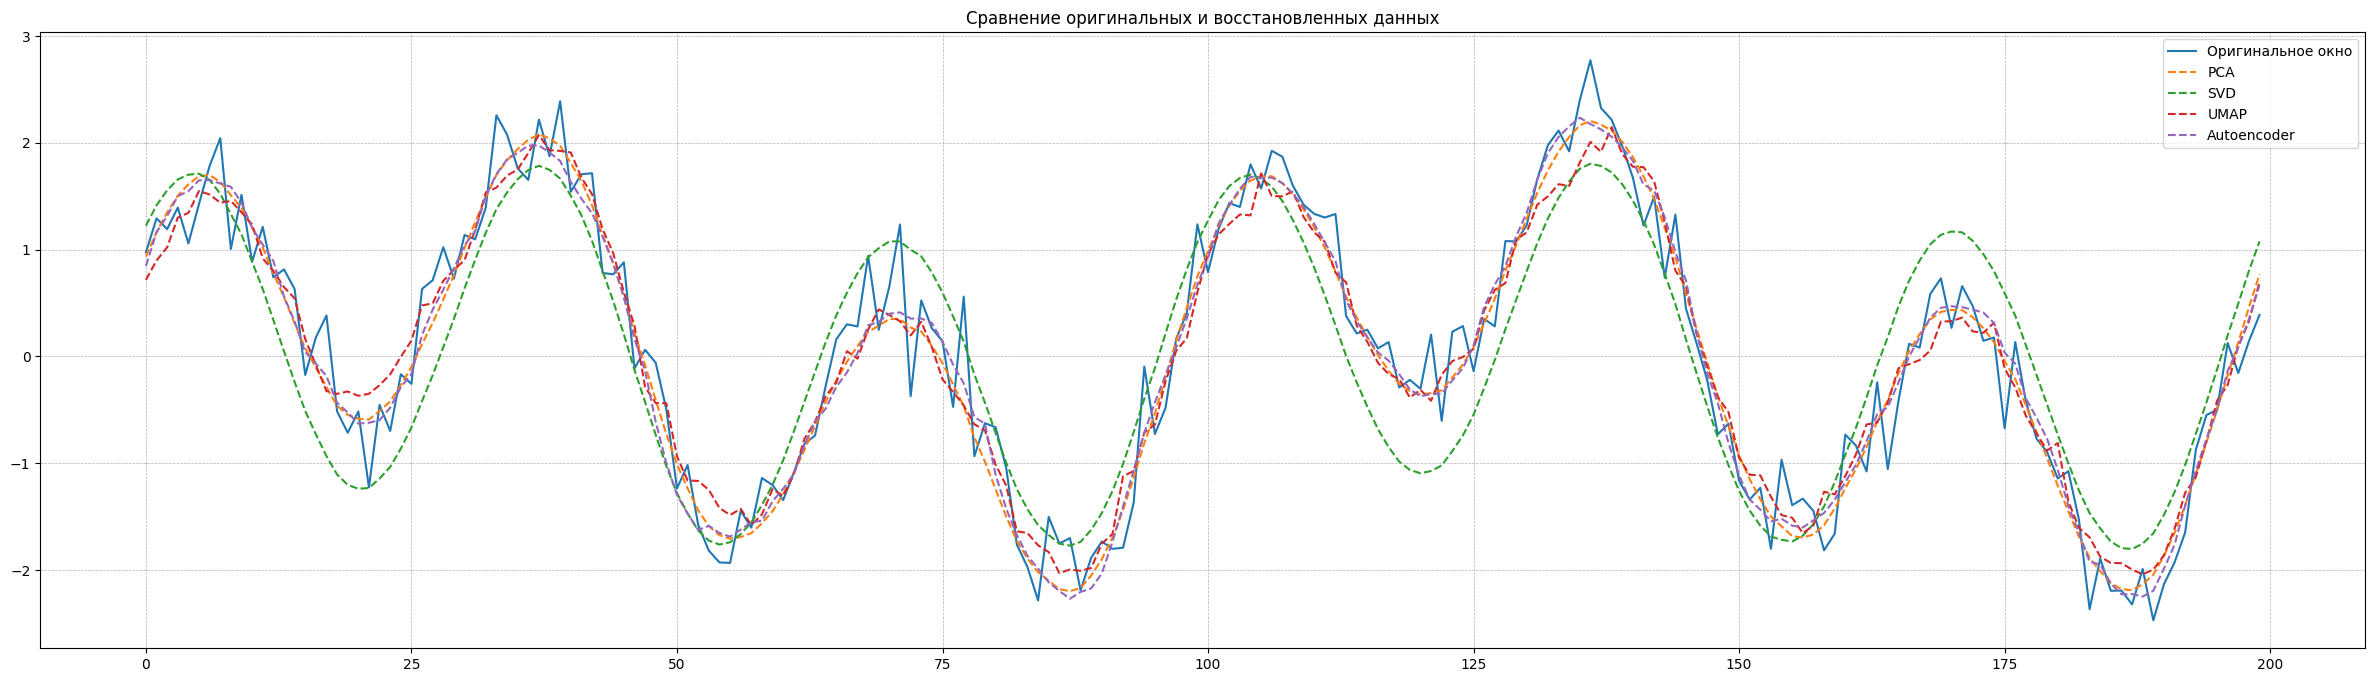

In [393]:
reconstructed_dict = {
    'PCA': X_pca_reconstructed, 
    'SVD': X_svd_reconstructed, 
    'UMAP': X_umap_reconstructed, 
    'Autoencoder': X_ae_reconstructed
    }

plt.figure(figsize=(30, 8))
plt.plot(X[:, 0][:200], label="Оригинальное окно")
for method, x in reconstructed_dict.items():
    plt.plot(x[:, 0][:200], label=method, linestyle="--")
plt.title("Сравнение оригинальных и восстановленных данных")
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Compression assesment

### a. Recovery accuracy
- MSE or RMSE: measures the difference between the original and recovered data.
- MAE: an alternative metric for robustness to outliers.
- Explained Variance: fraction of variance retained.

### b. Predictive ability
Train a prediction model on compressed data and evaluate its quality:
- Prediction Models(Linear Regression or Random Forest (baseline models), LSTM/GRU, Transformer-based models)
- Metrics(RMSE, MAE, R²)

### c. Maintaining the structure of the data
- Autocorrelation: Compare the autocorrelation functions of the original and reconstructed data.
- Seasonality: Check if key cycles (e.g., trends repeated every 24 hours) are preserved.

### d. Visualize the quality of the latent space
- t-SNE or UMAP to visualize clusters.
- Silhouette Score to assess the separability of data in compressed space.

## Metrcis for model comparison
- MSE/MAE for recovery.
- RMSE/MAE for prediction.
- Explained Variance (for linear methods only).
- Model trainability on compressed data: Compare the training time and quality of the prediction model for compressed and uncompressed data.

## Анализ результатов